<a href="https://colab.research.google.com/github/JoaoBarroso4/transfer_learning_cats_and_dogs/blob/main/transfer_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Passo 1: Importar as bibliotecas.**

In [8]:
# Importar bibliotecas necessárias
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from PIL import Image

# Montar Google Drive para salvar o modelo
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Passo 2: Baixar e extraiar o conjunto de dados**

In [3]:
# To get a new link, if the one below is not working, visit: https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O kagglecatsanddogs.zip

# Criar diretório para extrair o conjunto de dados
dataset_dir = '/content/cats_and_dogs'
os.makedirs(dataset_dir, exist_ok=True)

# Extrair o conjunto de dados
with zipfile.ZipFile('kagglecatsanddogs.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

# Verificar o conteúdo do diretório
os.listdir(dataset_dir)

--2024-06-10 18:22:49--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.59.26.17, 2600:1408:ec00:f86::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.59.26.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs.zip’

kagglecatsanddogs.z 100%[===================>] 786.67M  93.6MB/s    in 7.5s    

2024-06-10 18:22:57 (104 MB/s) - ‘kagglecatsanddogs.zip’ saved [824887076/824887076]



['readme[1].txt', 'CDLA-Permissive-2.0.pdf', 'PetImages']

**Passo 3: Pré-processamento dos dados**

In [9]:
# Função para verificar se a imagem está corrompida
def is_image_corrupted(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verificar se a imagem pode ser aberta
        return False
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image: {file_path}")
        return True

# Remover imagens corrompidas
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image_corrupted(file_path):
                os.remove(file_path)

# Diretório base onde estão as pastas "Cat" e "Dog"
base_dir = os.path.join(dataset_dir, 'PetImages')
remove_corrupted_images(base_dir)  # Remover imagens corrompidas

# Configurar data augmentation e preparação dos dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Dividir dados em treinamento e validação
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation'
)

Corrupted image: /content/cats_and_dogs/PetImages/Cat/666.jpg
Corrupted image: /content/cats_and_dogs/PetImages/Cat/Thumbs.db


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image: /content/cats_and_dogs/PetImages/Dog/11702.jpg
Corrupted image: /content/cats_and_dogs/PetImages/Dog/Thumbs.db
Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


**Passo 4: Construir o modelo**

In [10]:
# Construir o modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Passo 5: treinar o modelo**

In [11]:
# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

# Salvar o modelo
model.save('/content/drive/My Drive/cats_and_dogs_classifier.h5')

Epoch 1/15
100/100 - 82s - loss: 0.7634 - accuracy: 0.5420 - val_loss: 0.6759 - val_accuracy: 0.6200 - 82s/epoch - 819ms/step
Epoch 2/15
100/100 - 86s - loss: 0.6632 - accuracy: 0.6140 - val_loss: 0.6504 - val_accuracy: 0.6300 - 86s/epoch - 858ms/step
Epoch 3/15
100/100 - 88s - loss: 0.6523 - accuracy: 0.6185 - val_loss: 0.6629 - val_accuracy: 0.6150 - 88s/epoch - 880ms/step
Epoch 4/15
100/100 - 90s - loss: 0.6273 - accuracy: 0.6555 - val_loss: 0.5652 - val_accuracy: 0.7110 - 90s/epoch - 903ms/step
Epoch 5/15
100/100 - 90s - loss: 0.5984 - accuracy: 0.6775 - val_loss: 0.6033 - val_accuracy: 0.6700 - 90s/epoch - 900ms/step
Epoch 6/15
100/100 - 90s - loss: 0.5805 - accuracy: 0.6935 - val_loss: 0.6141 - val_accuracy: 0.6470 - 90s/epoch - 902ms/step
Epoch 7/15
100/100 - 81s - loss: 0.5758 - accuracy: 0.7075 - val_loss: 0.5757 - val_accuracy: 0.6950 - 81s/epoch - 812ms/step
Epoch 8/15
100/100 - 89s - loss: 0.5682 - accuracy: 0.7080 - val_loss: 0.5834 - val_accuracy: 0.7000 - 89s/epoch - 891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Passo 6: Avaliar o modelo**

250/250 [==============================] - 72s 286ms/step - loss: 0.5283 - accuracy: 0.7345
Loss: 0.5282887816429138
Accuracy: 0.7344937920570374


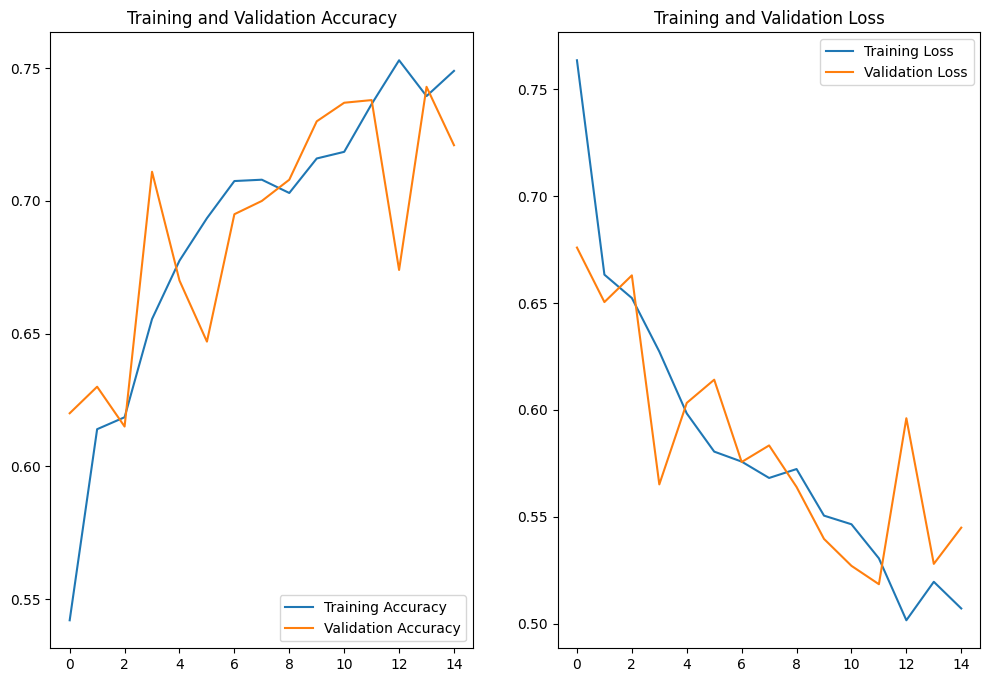

In [14]:
# Avaliar o desempenho do modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

import matplotlib.pyplot as plt

# Plotar gráficos de precisão e perda
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Chamar a função para plotar os gráficos
plot_training_history(history)